## Multi-class and Multi-Label Classification Using Support Vector Machines
### Name: Yuhan Chen. USC ID: 3009389875

In [180]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import hamming_loss,calinski_harabasz_score,silhouette_score
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTE
from sklearn import svm
from sklearn.cluster import KMeans
from scipy.spatial.distance import hamming
from sklearn.metrics import accuracy_score
from sklearn.metrics import zero_one_loss
import itertools
import warnings
warnings.filterwarnings('ignore')

In [181]:
df = pd.read_csv("../data/Frogs_MFCCs.csv")

In [182]:
traindf = df.sample(frac=0.70, random_state=200)
testdf = df.drop(traindf.index)
traindf.reset_index(drop=True,inplace=True)
testdf.reset_index(drop=True,inplace=True)

## (b) Each instance has three labels: Families, Genus, and Species. Each of the labels has multiple classes. We wish to solve a multi-class and multi-label problem. One of the most important approaches to multi-label classification is to train a classifier for each label (binary relevance). We first try this approach:

### i. Research exact match and hamming score/ loss methods for evaluating multi-label classification and use them in evaluating the classifiers in this problem.

In [227]:
trainFamily = pd.DataFrame(traindf.Family)
trainGenus = pd.DataFrame(traindf.Genus)
trainSpecies = pd.DataFrame(traindf.Species)
train_x = traindf.iloc[:,:-4]
testFamily = pd.DataFrame(testdf.Family)
testGenus = pd.DataFrame(testdf.Genus)
testSpecies = pd.DataFrame(testdf.Species)
test_x = testdf.iloc[:,:-4]

In [184]:
##reference: https://medium.datadriveninvestor.com/a-survey-of-evaluation-metrics-for-multilabel-classification-bb16e8cd41cd
def emr(y_true, y_pred):
    n = len(y_true)
    row_indicators = np.all(y_true == y_pred, axis = 1)
    exact_match_count = np.sum(row_indicators)
    return exact_match_count/n

def majority(data, index):
    cluster_label = data[index]
    majority_label =cluster_label.value_counts().index[0]
    return majority_label 

### ii. Train a SVM for each of the labels, using Gaussian kernels and one versus all classifiers. Determine the weight of the SVM penalty and the width of the Gaussian Kernel using 10 fold cross validation.1You are welcome to try to solve the problem with both standardized 2 and raw attributes and reportthe results.

In [185]:
c_range = [10**c for c in np.arange(-3,7, dtype=float)]
g_range = np.arange(0.1, 2.1, 0.1)
param = {'C':c_range, 'gamma':g_range}
m = SVC(kernel='rbf', random_state=100, max_iter = 999)
cv = StratifiedShuffleSplit(n_splits=10, random_state=66)

In [186]:
gsFamily = GridSearchCV(m, param_grid=param, cv=cv)
clfFamily = gsFamily.fit(train_x, trainFamily)

In [187]:
cFamily = clfFamily.best_params_['C']
gFamily = gsFamily.best_params_['gamma']
mFamily = SVC(C=cFamily, gamma=gFamily,kernel='rbf', random_state=100, max_iter = 999).fit(train_x, trainFamily)
pred_yFamily = pd.DataFrame(mFamily.predict(test_x))

In [188]:
gsGenus = GridSearchCV(m, param_grid=param, cv=cv)
clfGenus = gsGenus.fit(train_x, trainGenus)

In [189]:
cGenus = clfGenus.best_params_['C']
gGenus = gsGenus.best_params_['gamma']
mGenus = SVC(C=cGenus, gamma=gGenus,kernel='rbf', random_state=100, max_iter = 999).fit(train_x, trainGenus)
pred_yGenus = pd.DataFrame(mGenus.predict(test_x))

In [190]:
gsSpecies = GridSearchCV(m, param_grid=param, cv=cv)
clfSpecies = gsSpecies.fit(train_x, trainSpecies)
cSpecies = clfSpecies.best_params_['C']
gSpecies = gsSpecies.best_params_['gamma']
mSpecies = SVC(C=cSpecies, gamma=gSpecies,kernel='rbf', random_state=100, max_iter = 999).fit(train_x, trainSpecies)
pred_ySpecies = pd.DataFrame(mSpecies.predict(test_x))

In [191]:
pred_yTotal = pd.concat([pred_yFamily, pred_yGenus, pred_ySpecies], axis=1)
test_yTotal = pd.concat([testFamily, testGenus, testSpecies], axis=1)
pred_yTotal.columns = test_yTotal.columns

In [192]:
emr_value = emr(test_yTotal, pred_yTotal)

In [193]:
from sklearn.metrics import hamming_loss
hamming_score_Family =1- hamming_loss(testFamily,pred_yFamily)
print('The hamming score for Family is {}'.format(hamming_score_Family))
hamming_score_Genus =1- hamming_loss(testGenus,pred_yGenus)
print('The hamming score for Genus is {}'.format(hamming_score_Genus))
hamming_score_Species = 1-hamming_loss(testSpecies,pred_ySpecies)
print('The hamming score for Species is {}'.format(hamming_score_Species))

The hamming score for Family is 0.9888837424733673
The hamming score for Genus is 0.98471514590088
The hamming score for Species is 0.983325613710051


In [194]:
print('The best c for family is {}, The best gamma for family is {}'.format(cFamily, gFamily))
print('The best c for genus is {}, The best gamma for genus is {}'.format(cGenus, gGenus))
print('The best c for species is {}, The best gamma for species is {}'.format(cSpecies, gSpecies))

The best c for family is 100.0, The best gamma for family is 1.7000000000000002
The best c for genus is 10.0, The best gamma for genus is 1.0
The best c for species is 10.0, The best gamma for species is 1.8000000000000003


### iii. Repeat 1(b)ii with L1-penalized SVMs.3Remember to standardize4 the attributes. Determine the weight of the SVM penalty using 10 fold cross validation.

In [195]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

In [196]:
scaler = StandardScaler()
std_train_x = scaler.fit_transform(train_x)
std_test_x = scaler.fit_transform(test_x)
paramSVM = {'C':c_range}
mSVM = LinearSVC(penalty='l1', dual=False, random_state=100)

In [197]:
gsFamily_SVM = GridSearchCV(mSVM, param_grid=paramSVM, cv=cv)
clfFamily_SVM = gsFamily_SVM.fit(train_x, trainFamily)
cFamily_SVM = clfFamily_SVM.best_params_['C']
mFamily_SVM = LinearSVC(penalty='l1', C=cFamily_SVM, dual=False, random_state=999).fit(std_train_x, trainFamily)
pred_yFamily_SVM = pd.DataFrame(mFamily_SVM.predict(std_test_x))

In [228]:
gsGenus_SVM = GridSearchCV(mSVM, param_grid=paramSVM, cv=cv)
clfGenus_SVM = gsGenus_SVM.fit(train_x, trainGenus)
cGenus_SVM = clfGenus_SVM.best_params_['C']
mGenus_SVM = LinearSVC(penalty='l1', C=cGenus_SVM, dual=False, random_state=999).fit(std_train_x, trainGenus)
pred_yGenus_SVM = pd.DataFrame(mGenus_SVM.predict(std_test_x))

In [229]:
gsSpecies_SVM = GridSearchCV(mSVM, param_grid=paramSVM, cv=cv)
clfSpecies_SVM = gsSpecies_SVM.fit(train_x, trainSpecies)
cSpecies_SVM = clfSpecies_SVM.best_params_['C']
mSpecies_SVM = LinearSVC(penalty='l1', C=cSpecies_SVM, dual=False, random_state=999).fit(std_train_x, trainSpecies)
pred_ySpecies_SVM = pd.DataFrame(mSpecies_SVM.predict(std_test_x))

In [230]:
svmhamming_score_Family =1- hamming_loss(testFamily,pred_yFamily_SVM)
print('The hamming score for Family is {}'.format(svmhamming_score_Family))
svmhamming_score_Genus =1- hamming_loss(testGenus,pred_yGenus_SVM)
print('The hamming score for Genus is {}'.format(svmhamming_score_Genus))
svmhamming_score_Species = 1-hamming_loss(testSpecies,pred_ySpecies_SVM)
print('The hamming score for Species is {}'.format(svmhamming_score_Species))

The hamming score for Family is 0.9295970356646596
The hamming score for Genus is 0.9448818897637795
The hamming score for Species is 0.9499768411301528


In [231]:
print('The best c for family is {}'.format(cFamily_SVM))
print('The best c for genus is {}'.format(cGenus_SVM))
print('The best c for species is {}'.format(cSpecies_SVM))

The best c for family is 1000.0
The best c for genus is 10.0
The best c for species is 10.0


### (iv) Repeat 1(b)iii by using SMOTE or any other method you know to remedy class imbalance. Report your conclusions about the classifiers you trained.

In [232]:
sm = SMOTE()
paramSM = {'C':c_range}
mSM = LinearSVC(penalty='l1', dual=False, random_state=100)
cv = StratifiedShuffleSplit(n_splits=10, random_state=66)

In [241]:
sm_xFamily, sm_yFamily = sm.fit_resample(std_train_x, trainFamily)
gsFamily_SM = GridSearchCV(mSM, param_grid=paramSM, cv=cv)
clfFamily_SM = gsFamily_SM.fit(sm_xFamily, sm_yFamily)
cFamily_SM = clfFamily_SM.best_params_['C']
mFamily_SM = LinearSVC(penalty='l1', C=cFamily_SM, dual=False, random_state=100).fit(sm_xFamily, sm_yFamily)
pred_yFamily_SM = pd.DataFrame(mFamily_SM.predict(std_test_x))

KeyboardInterrupt: 

In [ ]:
sm_xGenus, sm_yGenus = sm.fit_resample(std_train_x, trainGenus)
gsGenus_SM = GridSearchCV(mSM, param_grid=paramSM, cv=cv)
clfGenus_SM = gsGenus_SM.fit(sm_xGenus, sm_yGenus)
cGenus_SM = clfGenus_SM.best_params_['C']
mGenus_SM = LinearSVC(penalty='l1', C=cGenus_SM, dual=False, random_state=100).fit(sm_xGenus, sm_yGenus)
pred_yGenus_SM = pd.DataFrame(mGenus_SM.predict(std_test_x))

In [ ]:
sm_xSpecies, sm_ySpecies = sm.fit_resample(std_train_x, trainSpecies)
gsSpecies_SM = GridSearchCV(mSM, param_grid=paramSM, cv=cv)
clfSpecies_SM = gsSpecies_SM.fit(sm_xSpecies, sm_ySpecies)
cSpecies_SM = clfSpecies_SM.best_params_['C']
mSpecies_SM = LinearSVC(penalty='l1', C=cSpecies_SM, dual=False, random_state=100).fit(sm_xSpecies, sm_ySpecies)
pred_ySpecies_SM = pd.DataFrame(mSpecies_SM.predict(std_test_x))

In [235]:
smhamming_score_Family =1- hamming_loss(testFamily,pred_yFamily_SM)
print('The hamming score for Family is {}'.format(smhamming_score_Family))
smhamming_score_Genus =1- hamming_loss(testGenus,pred_yGenus_SM)
print('The hamming score for Genus is {}'.format(smhamming_score_Genus))
smhamming_score_Species = 1-hamming_loss(testSpecies,pred_ySpecies_SM)
print('The hamming score for Species is {}'.format(smhamming_score_Species))

The hamming score for Family is 0.9258916164891153
The hamming score for Genus is 0.9166280685502548
The hamming score for Species is 0.9499768411301528


In [236]:
print('The best c for family is {}'.format(cFamily_SM))
print('The best c for genus is {}'.format(cGenus_SM))
print('The best c for species is {}'.format(cSpecies_SM))

The best c for family is 1.0
The best c for genus is 100.0
The best c for species is 1000.0


# 2. K-Means Clustering on a Multi-Class and Multi-Label Data Set

In [238]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score,silhouette_score

In [244]:
data_total = df.iloc[:,:-4]
distortions = []
s_score = {}
for k in np.arange(1, 51):
    kmeansModel = KMeans(n_clusters=k).fit(data_total)
    distortions.append(kmeansModel.inertia_)
    if k > 1:
        s_score[k] = silhouette_score(data_total, kmeansModel.labels_)

In [245]:
op = max(s_score, key=s_score.get)
print(op)
print('The max Silhouettes score is: {}'.format(max(s_score.values())))

4
The max Silhouettes score is: 0.3787509343305295


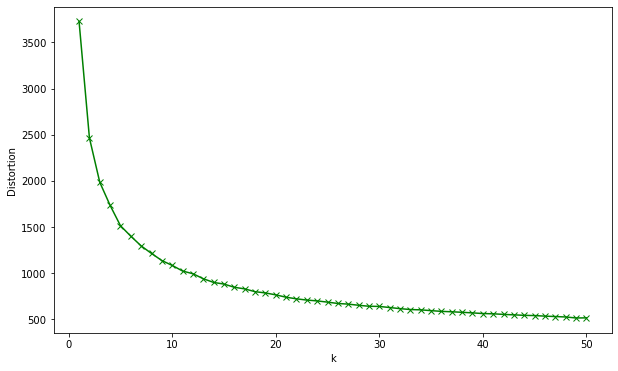

In [246]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(K, distortions, 'gx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.show()

### (b) In each cluster, determine which family is the majority by reading the true labels.Repeat for genus and species.

In [247]:
from collections import Counter

kmeans_m = KMeans(n_clusters=op_k, random_state=999)
kmeans_clf = kmeans_m.fit(data_total)
label_data = pd.Series(kmeans_clf.labels_)
dfFamily = df['Family']
majorityf = {}
for i in range(4):
    index = label_data.index[label_data == i].tolist()
    majorityf[i] = majority(dfFamily, index)
    print(majorityf[i])

Hylidae
Dendrobatidae
Leptodactylidae
Hylidae


In [248]:
dfg = df['Genus']
majorityg = {}
for i in range(4):
    index = label_data.index[label_data == i].tolist()
    majorityg[i] = majority(dfg, index)
    print(majorityg[i])

Hypsiboas
Ameerega
Adenomera
Hypsiboas


In [249]:
dfs = df['Species']
majoritys = {}
for i in range(4):
    index = label_data.index[label_data == i].tolist()
    majoritys[i] = majority(dfs, index)
    print(majoritys[i])

HypsiboasCordobae
Ameeregatrivittata
AdenomeraHylaedactylus
HypsiboasCinerascens


In [250]:
list0 =[majorityf[0],majorityg[0],majoritys[0]]
list1 =[majorityf[1],majorityg[1],majoritys[1]]
list2 =[majorityf[2],majorityg[2],majoritys[2]]
list3 =[majorityf[3],majorityg[3],majoritys[3]]

### Now for each cluster you have a majority label triplet (family, genus, species).Calculate the average Hamming distance, Hamming score, and Hamming loss5between the true labels and the labels assigned by clusters

In [251]:
c0=pd.DataFrame(list0).T
c1=pd.DataFrame(list1).T
c2=pd.DataFrame(list2).T
c3=pd.DataFrame(list3).T
c_index = pd.DataFrame([0,1,2,3])
C_total = pd.concat([c0,c1,c2,c3],ignore_index=True)
cluter_table=pd.concat([c_index,C_total],axis=1,ignore_index=True)
cluter_table.columns = ['Index','Family','Genus','Species']
train_x=df.iloc[:,:22]
train_y=df.iloc[:,22:25]

In [252]:
hammingdis=[]
hammingloss=[]
hammingscore=[]
Yh=list(itertools.chain.from_iterable(train_y.values.tolist()))
for i in np.arange(1,51,1):
    km=KMeans(n_clusters=4,random_state=i)
    label=km.fit_predict(train_x)
    y=pd.DataFrame(columns=train_y.columns,index=train_y.index)
    y=pd.concat([pd.DataFrame(label,columns=['Index']),y],axis=1)
    for j in np.unique(label):
            y.loc[y['Index']==j,['Family']]= cluter_table.loc[j]['Family']
            y.loc[y['Index']==j,['Genus']]=cluter_table.loc[j]['Genus']
            y.loc[y['Index']==j,['Species']]=cluter_table.loc[j]['Species']
            yh=list(itertools.chain.from_iterable(y.iloc[:,1:].values.tolist()))    
    hammingdis.append(hamming(Yh,yh))
    hammingscore.append(accuracy_score(Yh,yh))
    hammingloss.append(hamming_loss(Yh,yh))

In [253]:
print('The average hamming distance is {},\n the standard deviation of hamming distance is {}'.format(np.mean(hammingdis), np.std(hammingdis)))

The average hamming distance is 0.7780171415334723,
 the standard deviation of hamming distance is 0.2059554573872954


In [254]:
print('The average hamming loss is {},\n the standard deviation of hamming loss is {}'.format(np.mean(hammingloss), np.std(hammingloss)))

The average hamming loss is 0.7780171415334723,
 the standard deviation of hamming loss is 0.2059554573872954


In [255]:
print('The average hamming score is {},\n the standard deviation of hamming score is {}'.format(np.mean(hammingscore), np.std(hammingscore)))

The average hamming score is 0.22198285846652768,
 the standard deviation of hamming score is 0.20595545738729537


In [256]:
from IPython.display import Image
Image("../data/final.jpg")